## Chapter 4. Path tracing: Homework
### Initialize

In [1]:
from enum import Enum
from time import time
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
import drjit as dr
import mitsuba as mi

from util import imshow_compare, imshow_compare_many

mi.set_variant('cuda_ad_rgb', 'llvm_ad_rgb')
print(f"{mi.variant() = }\n")

cbox_scene = mi.load_dict(mi.cornell_box())
vmis_scene = mi.load_file("./scene/veach-mis/scene.xml")
vmis_delta_scene = mi.load_file("./scene/veach-mis/scene_delta.xml")

scene_dict = {'Cornell box': cbox_scene, 'Veach MIS': vmis_scene, 'Veach MIS w/ Dirac Delta': vmis_delta_scene}

# -------------------- Assertions --------------------
assert isinstance(cbox_scene, mi.Scene)
assert isinstance(vmis_scene, mi.Scene)
assert isinstance(vmis_delta_scene, mi.Scene)

mi.variant() = 'cuda_ad_rgb'



### See GT

{'Cornell box': TensorXf(shape=(256, 256, 3)), 'Veach MIS': TensorXf(shape=(720, 1280, 3)), 'Veach MIS w/ Dirac Delta': TensorXf(shape=(720, 1280, 3))}


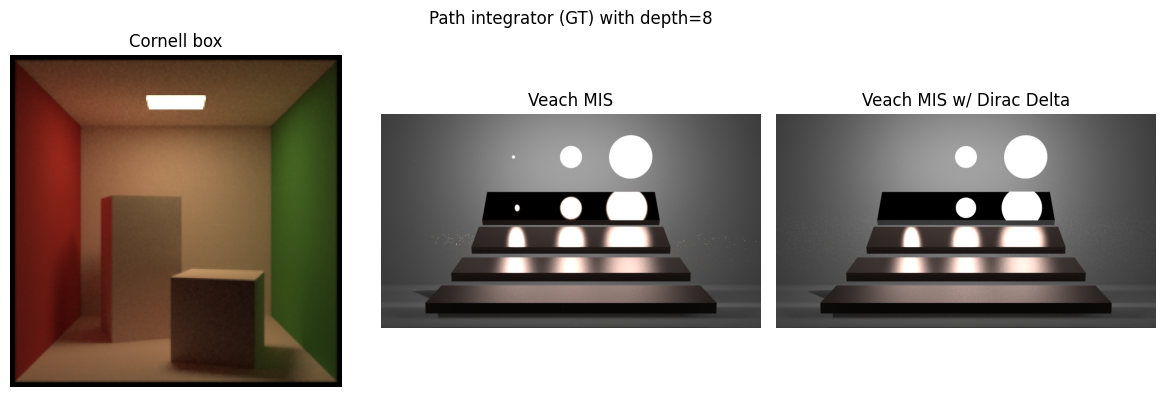

In [2]:
# -------------------- Parameters --------------------
figsize = (12, 4)
spp = 256
depth = 8

# -------------------- Visualize --------------------
integrator = mi.load_dict({'type': 'path', 'max_depth': depth, 'rr_depth': depth})
img_gt_dict = dict()

fig, axes = plt.subplots(1, len(scene_dict), figsize=figsize)
for ax, (label, scene) in zip(axes, scene_dict.items()):
    img = mi.render(scene, integrator=integrator, spp=spp)
    img_gt_dict[label] = img

    ax.imshow(mi.Bitmap(dr.clip(img, 0, 1)**(1/2.2)))
    ax.set_title(label)
    ax.set_axis_off()
fig.suptitle(f"Path integrator (GT) with {depth=}")
fig.tight_layout()
print(img_gt_dict)

-----
## Ver. 0.7 Path Integrator with a fixed detph

In [3]:
class PathIntegrator(mi.ad.integrators.common.ADIntegrator):
    def __init__(self, props = mi.Properties()):
        super().__init__(props)
        self.max_depth = int(props.get('max_depth', 8))
    
    def sample(self,
               mode: dr.ADMode, # NOT USED NOW (differentiable rendering)
               scene: mi.Scene,
               sampler: mi.Sampler,
               ray: mi.Ray3f,
               active: mi.Bool,
               **kwargs # Absorbs unused arguments
               ):
        #################### TODO start ####################
        bsdf_ctx = mi.BSDFContext()
        L = mi.Spectrum(0.0)
        # β = # TODO

        # prev_si = dr.zeros(mi.SurfaceInteraction3f)
        # prev_bsdf_pdf = # TODO
        # prev_bsdf_delta = # TODO

        for i in range(self.max_depth):
            # ---------- Direct emission ----------
            si = scene.ray_intersect(ray) # $p_{i+1}$
            
            ################
            ##### TODO #####
            ################

            L += 0.0 # TODO

            if i == self.max_depth-1:
                break
            bsdf = si.bsdf()
            # ---------- Emitter sampling ----------
            ds, em_weight = scene.sample_emitter_direction(si, sampler.next_2d())

            ################
            ##### TODO #####
            ################

            L += 0.0 # TODO

            # ---------- BSDF sampling ----------
            bsdf_sample, bsdf_weight = bsdf.sample(bsdf_ctx, # $\omega_{i+1,i+2}$
                                                   si,
                                                   sampler.next_1d(),
                                                   sampler.next_2d()
                                                  )
            ray = si.spawn_ray(si.to_world(bsdf_sample.wo))

            # β *= # TODO
            # prev_si = # TODO
            # prev_bsdf_pdf = # TODO
            # prev_bsdf_delta = # TODO

        #################### TODO end ####################
        return L, active, [], None
    
    def mis_weight(self, pdf_a, pdf_b):
        # w = 0
        # w = pdf_a / (pdf_a + pdf_b)
        a2 = dr.sqr(pdf_a)
        b2 = dr.sqr(pdf_b)
        w = a2 / (a2 + b2)
        return dr.select(dr.isfinite(w), w, 0)

mi.register_integrator("mypath", lambda props: PathIntegrator(props))

Render the result

In [4]:
spp = 512
mypath = mi.load_dict({'type': "mypath", 'max_depth': 8})
img_ours_dict = {}
for label, scene in scene_dict.items():
    img = mi.render(scene, integrator=mypath, spp=spp)
    img_ours_dict[label] = img

Visualize

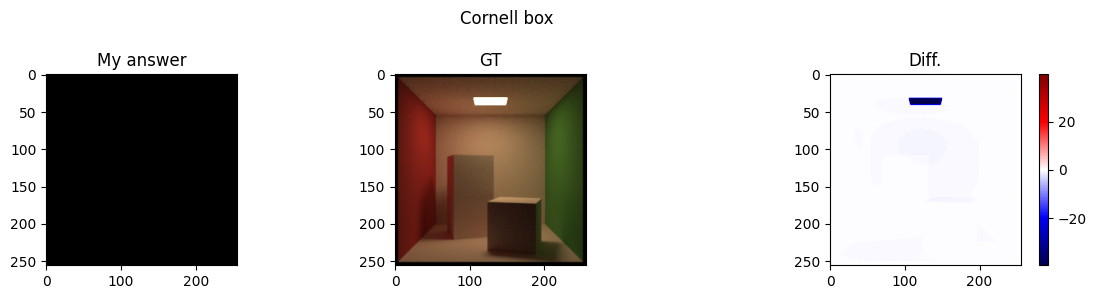

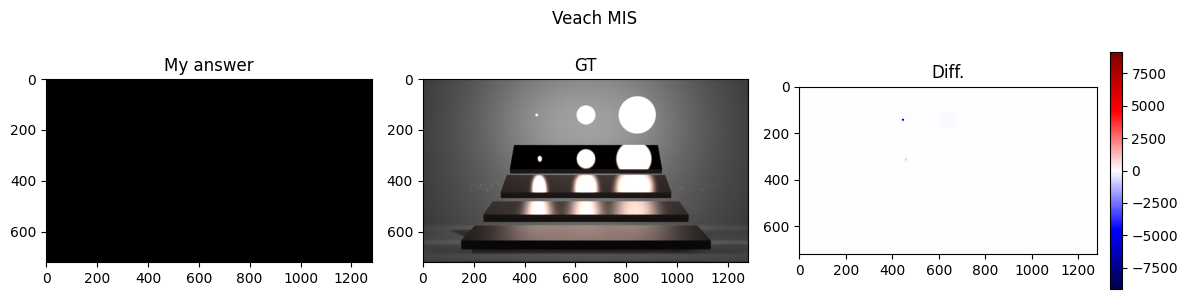

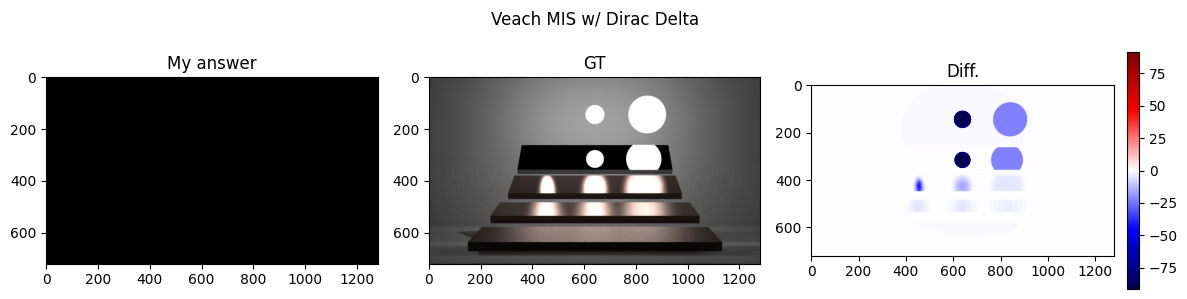

In [5]:
for label in scene_dict:
    fig = plt.figure(figsize=(12, 3))
    imshow_compare(img_ours_dict[label].numpy(), img_gt_dict[label].numpy())
    plt.suptitle(label)
    plt.tight_layout()